In [1]:
import data_preprocess_functions as dp_f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import math

In [2]:
Dir='/nfs/kloe/einstein4/martino/'
mode='VariableCone'
path=Dir+'PKL/Zprime'+mode+'/'
#dumper_path=path

In [3]:
data_singleBJet=pd.read_csv(path+'singleBJet_df.csv')
data_singleBTrk=pd.read_csv(path+'singleBTrk_df.csv')
#data_lightJet=pd.read_csv(path+'lightJet_df.csv')
#data_lightTrk=pd.read_csv(path+'lightTrk_df.csv')

#data_singleBJet_02=pd.read_csv(path+'singleBJet_0.2_df.csv')
#data_singleBTrk_02=pd.read_csv(path+'singleBTrk_0.2_df.csv')

#data_singleBTrk.shape,data_singleBTrk_02.shape

In [4]:
from sklearn.model_selection import train_test_split

def preprocess_DF(data, cut_str):
    data_cp=data.copy()
    if cut_str!='':
        data_cp=data_cp.query(cut_str)
        
    data_cp['pT']=data_cp['pT'].apply(lambda x: math.log(x))
    data_cp=data_cp.rename(columns={'pT': 'log_pt'})
    data_cp=data_cp.rename(columns={'Eta': 'eta'})
    data_cp=data_cp.rename(columns={'Phi': 'phi'})
    data_cp=data_cp.rename(columns={'Theta': 'theta'})
    data_cp['DR']=data_cp['DR'].apply(lambda x: math.log(x))
    data_cp=data_cp.rename(columns={'DR': 'log_dr'})
    data_cp['pTfrac']=data_cp['pTfrac'].apply(lambda x: math.log(x))
    data_cp=data_cp.rename(columns={'pTfrac': 'log_ptfrac'})
#    data_cp['pZfrac']=data_cp['pZfrac'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'pZfrac': 'log_pzfrac'})
    
#    data_cp['p3fracJetE']=data_cp['p3fracJetE'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'p3fracJetE': 'log_p3fracJetE'})
    data_cp.drop('p3fracJetE',axis=1,inplace=True)
#    data_cp['closestJetDR']=data_cp['closestJetDR'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'closestJetDR': 'log_closestJetDR'})
#    data_cp['closestJetDRtrkjet']=data_cp['closestJetDRtrkjet'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'closestJetDRtrkjet': 'log_closestJetDRtrkjet'})
    data_cp.drop('closestJetDRtrkjet',axis=1,inplace=True)
    data_cp.drop('closestJetDeta',axis=1,inplace=True)
    data_cp.drop('E',axis=1,inplace=True)
#    data_cp['E']=data_cp['E'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'E': 'log_E'})
    data_cp.drop('Deta',axis=1,inplace=True)
    data_cp.drop('Dphi',axis=1,inplace=True)    
#    data_cp.drop('phi',axis=1,inplace=True)
    data_cp.drop('pZfrac',axis=1,inplace=True)
    data_cp.drop('closestJetDphi',axis=1,inplace=True)
#    data_cp.drop('theta',axis=1,inplace=True)
    data_cp.drop('closestJetDR',axis=1,inplace=True)
    data_cp.drop('isfromBoutDR',axis=1,inplace=True)
    data_cp.drop('trk_d0',axis=1,inplace=True)
    data_cp.drop('isfromtau',axis=1,inplace=True)
    data_cp.drop('incl_origin',axis=1,inplace=True)
#    data_cp.drop('excl_origin',axis=1,inplace=True)
    data_cp.drop('trk_z0SinTheta',axis=1,inplace=True)
    
    return data_cp



def old_sig_bkg_selector(data):
    signal=data.query('excl_origin==13 or excl_origin==103 or excl_origin==113 or excl_origin==15 or excl_origin==105 or excl_origin==115' )#tracks from BD
    bkg=data.query('excl_origin==0 or excl_origin==2 or excl_origin==4 or excl_origin==6')#other tracks

#    drop_list=['isfromBD']
    signal=signal.drop('isfromBD', 1)
    signal=signal.drop('excl_origin',1)
    bkg=bkg.drop('isfromBD', 1)
    bkg=bkg.drop('excl_origin',1)
    #columns_list=signal.columns
    

    print('bkg size: ',bkg.shape, '; signal size: ',signal.shape, '; S/B ratio: ',signal.shape[0]/bkg.shape[0])
    return signal,bkg


def sig_bkg_selector(data):
    signal=data.query('isfromBD==1')#tracks from BD
    bkg=data.query('isfromBD==0')#other tracks

#    drop_list=['isfromBD']
    signal=signal.drop('isfromBD', 1)
    signal=signal.drop('excl_origin',1)
    bkg=bkg.drop('isfromBD', 1)
    bkg=bkg.drop('excl_origin',1)
    #columns_list=signal.columns

    print('bkg size: ',bkg.shape, '; signal size: ',signal.shape, '; S/B ratio: ',signal.shape[0]/bkg.shape[0])
    return signal,bkg

def plot_sig_bkg(X,y,columns_list,density_f,mode,path):
    fig=plt.figure(figsize=(24,24))
    gs = gridspec.GridSpec(nrows=4, ncols=3, width_ratios=[1,1,1],figure=fig)
#    fig.suptitle('No cut')

    for i in range(0,len(columns_list)):
        ax=fig.add_subplot(gs[i])
        im = ax.hist(X[np.where(y==0),i][0],bins=100,alpha=0.5,density=density_f,label='bkg')
        im = ax.hist(X[np.where(y==1),i][0],bins=100,alpha=0.5,density=density_f,label='signal')
        ax.set_xlabel(columns_list[i])
        if mode=='log':
            ax.set_yscale('log')
        ax.legend()

    plt.savefig(path+'vars_sig_bkg'+mode+'.pdf')
    plt.show()
    
def dataset_split(X,y,test_frac,path):
#    test_frac=0.2

    scaler_1 = StandardScaler().fit(X[np.where(y==1)])
    scaler_0 = StandardScaler().fit(X[np.where(y==0)])

    X1_std=scaler_1.transform(X[np.where(y==1)])
    X0_std=scaler_0.transform(X[np.where(y==0)])

    y_s=np.concatenate((np.zeros(len(X0_std)),np.ones(len(X1_std))))
    X_s=np.concatenate((X0_std,X1_std))

    X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=test_frac)

    y_train_cat=to_categorical(y_train)
    y_test_cat=to_categorical(y_test)
    
    np.savetxt(path+"X_train.csv",X_train,delimiter=',')
    np.savetxt(path+"X_test.csv",X_test,delimiter=',')
    np.savetxt(path+"y_train.csv",y_train,delimiter=',')
    np.savetxt(path+"y_train_cat.csv",y_train_cat,delimiter=',')
    np.savetxt(path+"y_test.csv",y_test,delimiter=',')
    np.savetxt(path+"y_test_cat.csv",y_test_cat,delimiter=',')

    print('saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat')
    print('in: ',path)
    
    return X_train, X_test, y_train, y_train_cat, y_test, y_test_cat


In [5]:
data_singleBTrk.head()

,pT,Eta,Deta,Theta,Phi,Dphi,E,DR,pTfrac,pZfrac,...,excl_origin,isfromBD,isfromBoutDR,isfromtau,closestJetDR,closestJetDeta,closestJetDphi,closestJetDRtrkjet,trk_d0,trk_z0SinTheta
0,18360.250000,0.162893,-0.082021,1.408619,1.329977,0.007306,18604.896484,0.082346,0.033768,0.068243,...,105.0,1.0,0.0,0.0,0.62517,-0.623467,0.319938,0.700765,0.101151,0.030923
1,29422.203125,0.160251,-0.079379,1.411227,1.332439,0.004843,29801.125000,0.079527,0.054113,0.107570,...,105.0,1.0,0.0,0.0,0.62517,-0.620825,0.317476,0.697291,0.018875,-0.013373
2,786.279236,0.006668,0.074203,1.564128,1.363337,-0.026054,798.587708,0.078644,0.001446,0.000119,...,0.0,0.0,0.0,0.0,0.62517,-0.467242,0.286578,0.548126,0.127402,-0.483250
3,7548.209473,-0.015929,0.096801,1.586725,1.318640,0.018642,7550.457031,0.098579,0.013883,-0.002732,...,5.0,0.0,0.0,0.0,0.62517,-0.444645,0.331275,0.554483,0.012508,0.010769
4,2213.738525,0.161875,-0.081003,1.409624,1.401519,-0.064237,2247.144043,0.103382,0.004071,0.008176,...,105.0,1.0,0.0,0.0,0.62517,-0.622449,0.248396,0.670181,-0.378161,-0.168460


In [6]:
cut='pT>1000 and abs(trk_d0)<1. and abs(trk_z0SinTheta)<1.5'
#cut='isfromBoutDR==0 and pZfrac>0'

#cut='isfromBoutDR==0 and isfromtau==0'
#cut=''

In [7]:
#print(1.-data_singleBTrk.query(cut).shape[0]/data_singleBTrk.shape[0])
data_singleBTrk_prepr_cut=preprocess_DF(data_singleBTrk,cut)
#data_lightTrk_prepr_cut=preprocess_DF(data_lightTrk,cut)

#print(1.-data_lightTrk.shape[0]/data_lightTrk.shape[0])
#data_lightTrk_prepr=preprocess_DF(data_lightTrk,'')


In [8]:
columns_list=data_singleBTrk_prepr_cut.columns
columns_list

Index(['log_pt', 'eta', 'theta', 'phi', 'log_dr', 'log_ptfrac', 'excl_origin',
       'isfromBD'],
      dtype='object')

In [9]:
columns_list=np.array(['log_pt', 'eta', 'theta', 'phi', 'log_dr', 'log_ptfrac'])

#columns_list=np.array(['log_pt', 'eta', 'Deta', 'phi', 'Dphi', 'log_dr', 'log_ptfrac', 'log_p3fracJetE'])

In [10]:
path

'/nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/'

bkg size:  (501000, 6) ; signal size:  (228510, 6) ; S/B ratio:  0.4561077844311377
new bkg size:  (501000, 6) ; new signal size:  (228510, 6) ; new S/B ratio:  0.4561077844311377
created:  /nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/singleBJetcut_oldcut/
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  /nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/singleBJetcut_oldcut/


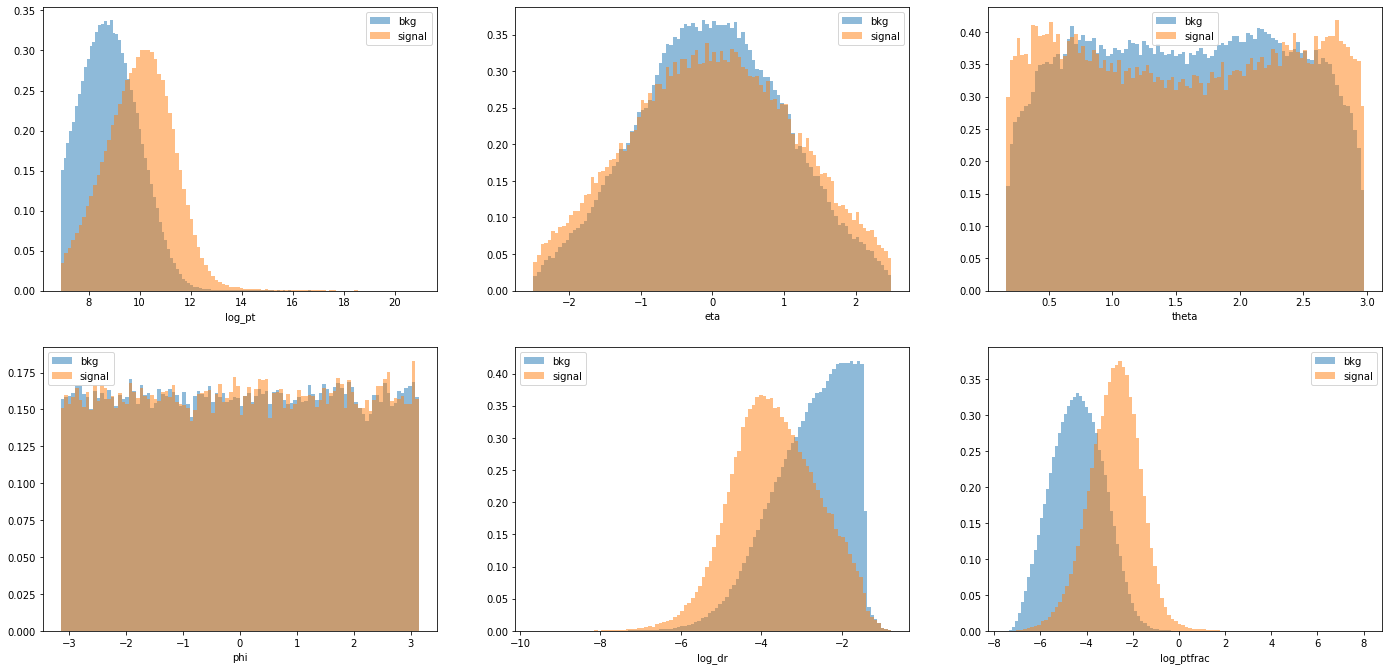

In [10]:
mode='cut'
jet='singleB'
signal,bkg=sig_bkg_selector(data_singleBTrk_prepr_cut)
X,y=dp_f.Sig_to_Bkg_eq(signal,bkg,0.1)
import os

data_out_dir=jet+'Jet'+mode+'_oldcut/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_singleB, X_train_singleB_scaled, X_test_singleB, X_test_singleB_scaled, y_train_singleB, y_train_singleB_cat, y_test_singleB, y_test_singleB_cat=dp_f.dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_singleB,y_train_singleB,columns_list,True,'',path+data_out_dir)

bkg size:  (1796383, 8) ; signal size:  (272480, 8) ; S/B ratio:  0.15168257548640796
new bkg size:  (1796383, 8) ; new signal size:  (272480, 8) ; new S/B ratio:  0.15168257548640796
created:  /nfs/kloe/einstein4/martino/PKL/ZprimeFixedCone/singleBJetisfromBDinDRcone_notaus_02_extendedvars/
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  /nfs/kloe/einstein4/martino/PKL/ZprimeFixedCone/singleBJetisfromBDinDRcone_notaus_02_extendedvars/


IndexError: index 8 is out of bounds for axis 1 with size 8

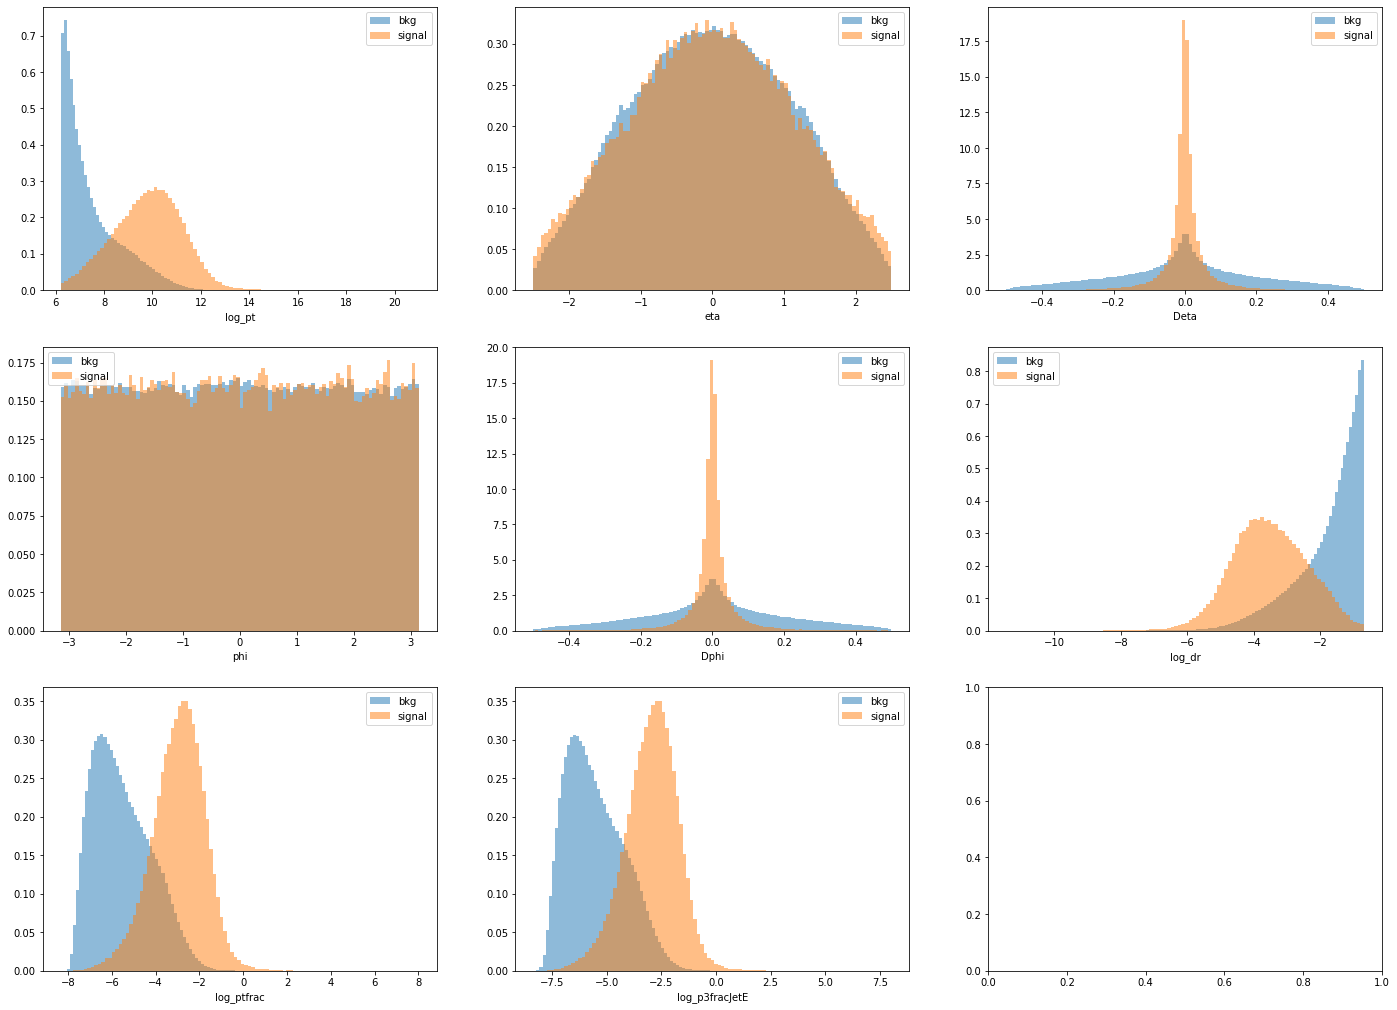

In [10]:
mode='isfromBDinDRcone_notaus_02'
jet='singleB'
signal,bkg=sig_bkg_selector(data_singleBTrk_prepr_cut)
X,y=dp_f.Sig_to_Bkg_eq(signal,bkg,0.1)
import os

data_out_dir=jet+'Jet'+mode+'_extendedvars/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_singleB, X_train_singleB_scaled, X_test_singleB, X_test_singleB_scaled, y_train_singleB, y_train_singleB_cat, y_test_singleB, y_test_singleB_cat=dp_f.dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_singleB,y_train_singleB,columns_list,True,'',path+data_out_dir)

bkg size:  (202287, 6) ; signal size:  (235, 6) ; S/B ratio:  0.0011617157800550702
new bkg size:  (202287, 6) ; new signal size:  (235, 6) ; new S/B ratio:  0.0011617157800550702
created:  ../PKL/ZprimeVariableCone_m/lightJet/
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  ../PKL/ZprimeVariableCone_m/lightJet/


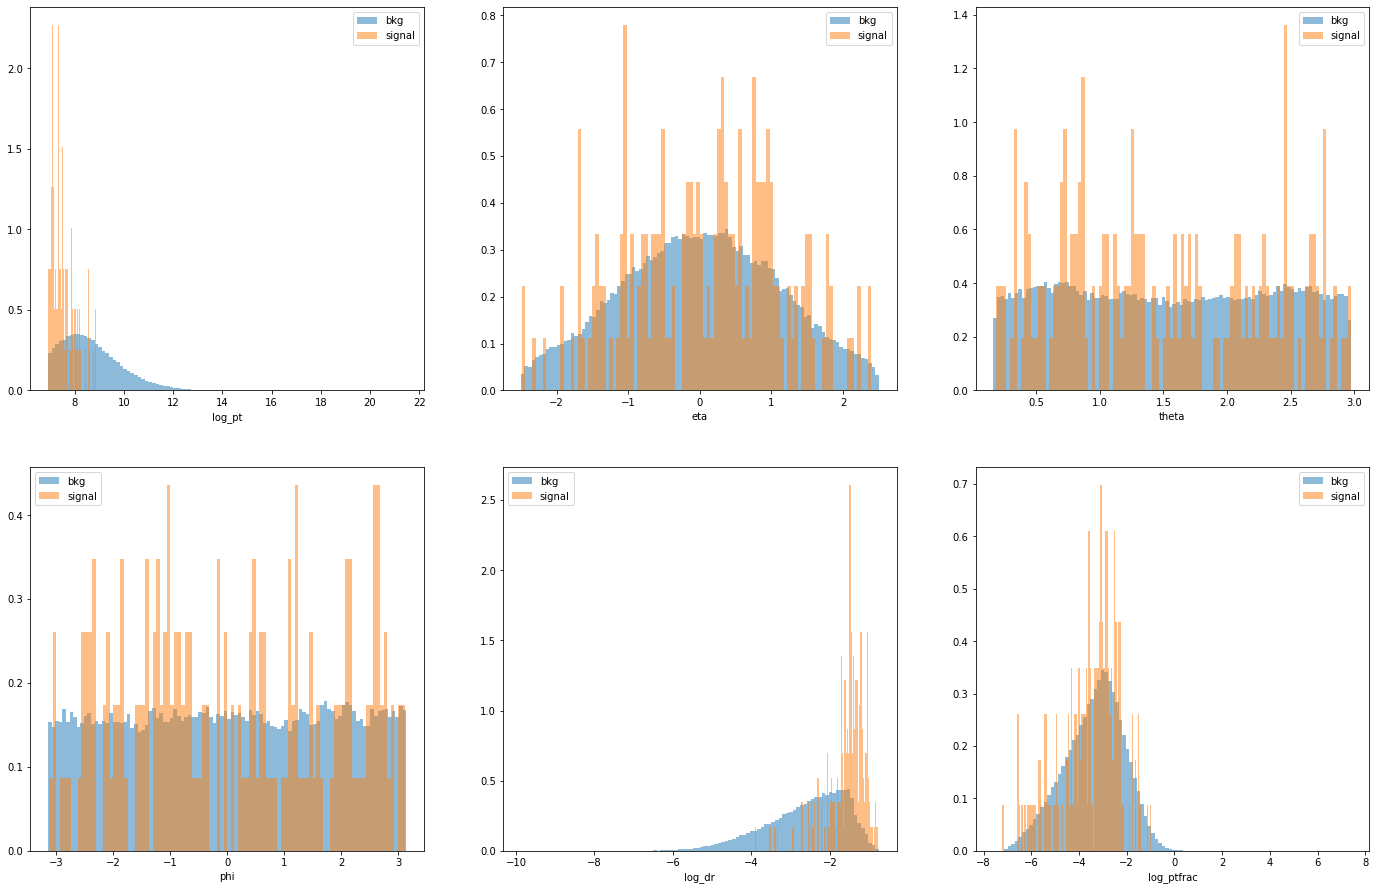

In [32]:
jet='light'
signal,bkg=sig_bkg_selector(data_lightTrk_prepr)
X,y=dp_f.Sig_to_Bkg_eq(signal,bkg,0.00001)

data_out_dir=jet+'Jet/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_light, X_train_light_scaled, X_test_light, X_test_light_scaled, y_train_light, y_train_light_cat, y_test_light, y_test_light_cat=dp_f.dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_light,y_train_light,columns_list,True,'',path+data_out_dir)


bkg size:  (55518, 6) ; signal size:  (219170, 6) ; S/B ratio:  3.9477286645772542
bkg size:  (27498, 6) ; signal size:  (476, 6) ; S/B ratio:  0.017310349843624992
new bkg size:  (27498, 6) ; new signal size:  (219170, 6) ; new S/B ratio:  7.970397847116154
/nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/mixedJet_oldcut/ already exists
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  /nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/mixedJet_oldcut/


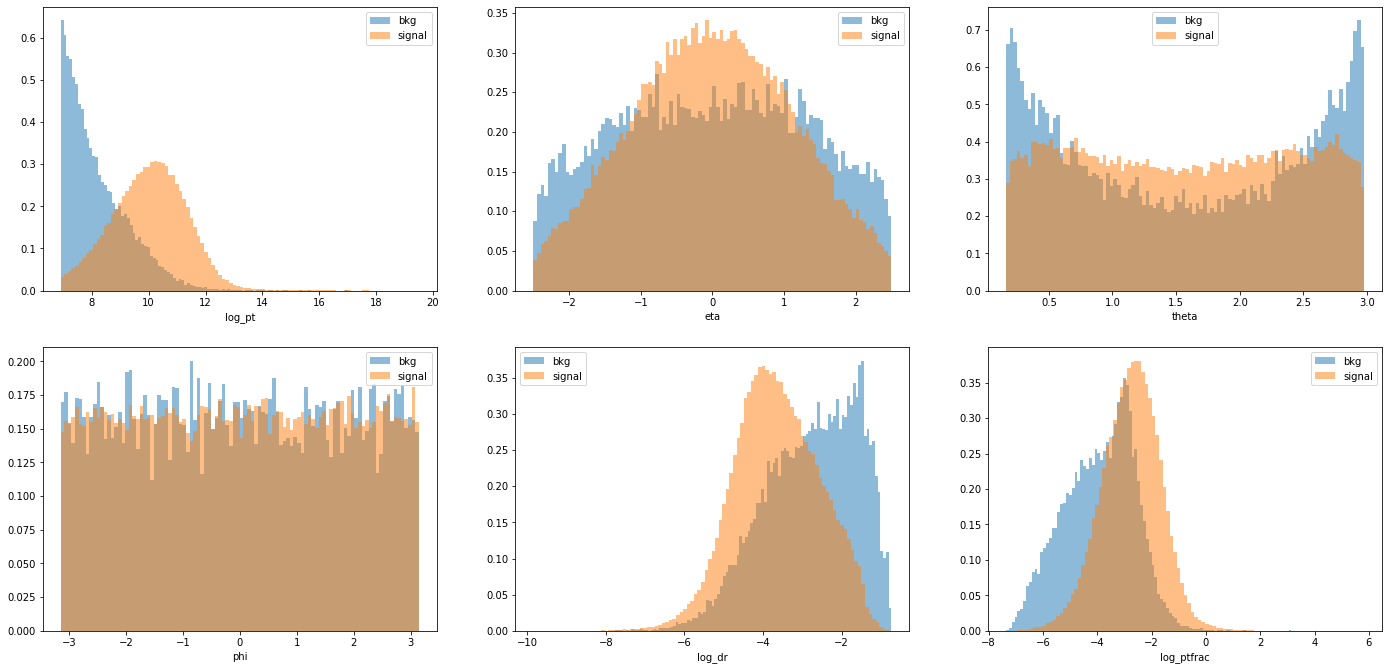

In [23]:
jet='mixed'
Bsignal_cut,Bbkg_cut=old_sig_bkg_selector(data_singleBTrk_prepr_cut)
Lsignal_cut,Lbkg_cut=old_sig_bkg_selector(data_lightTrk_prepr_cut)

X,y=dp_f.Sig_to_Bkg_eq(Bsignal_cut,Lbkg_cut,0.01)

import os

data_out_dir=jet+'Jet_oldcut/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_mixed, X_train_mixed_scaled, X_test_mixed, X_test_mixed_scaled, y_train_mixed, y_train_mixed_cat, y_test_mixed, y_test_mixed_cat=dp_f.dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_mixed,y_train_mixed,columns_list,True,'',path+data_out_dir)


In [30]:
!ls -l /nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/wrongscalingJet/

total 198112
-rw-rw----+ 1 centonze gruppo1     44596 Jul 22 12:48 vars_sig_bkg.pdf
-rw-rw----+ 1 centonze gruppo1  27220460 Jul 22 12:47 X_test.csv
-rw-rw----+ 1 centonze gruppo1 108879160 Jul 22 12:47 X_train.csv
-rw-rw----+ 1 centonze gruppo1   8895400 Jul 22 12:48 y_test_cat.csv
-rw-rw----+ 1 centonze gruppo1   4447700 Jul 22 12:47 y_test.csv
-rw-rw----+ 1 centonze gruppo1  35581600 Jul 22 12:47 y_train_cat.csv
-rw-rw----+ 1 centonze gruppo1  17790800 Jul 22 12:47 y_train.csv


bkg size:  (501000, 6) ; signal size:  (228510, 6) ; S/B ratio:  0.4561077844311377
new bkg size:  (501000, 6) ; new signal size:  (228510, 6) ; new S/B ratio:  0.4561077844311377
/nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/wrongscalingJet/ already exists
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  /nfs/kloe/einstein4/martino/PKL/ZprimeVariableCone/wrongscalingJet/


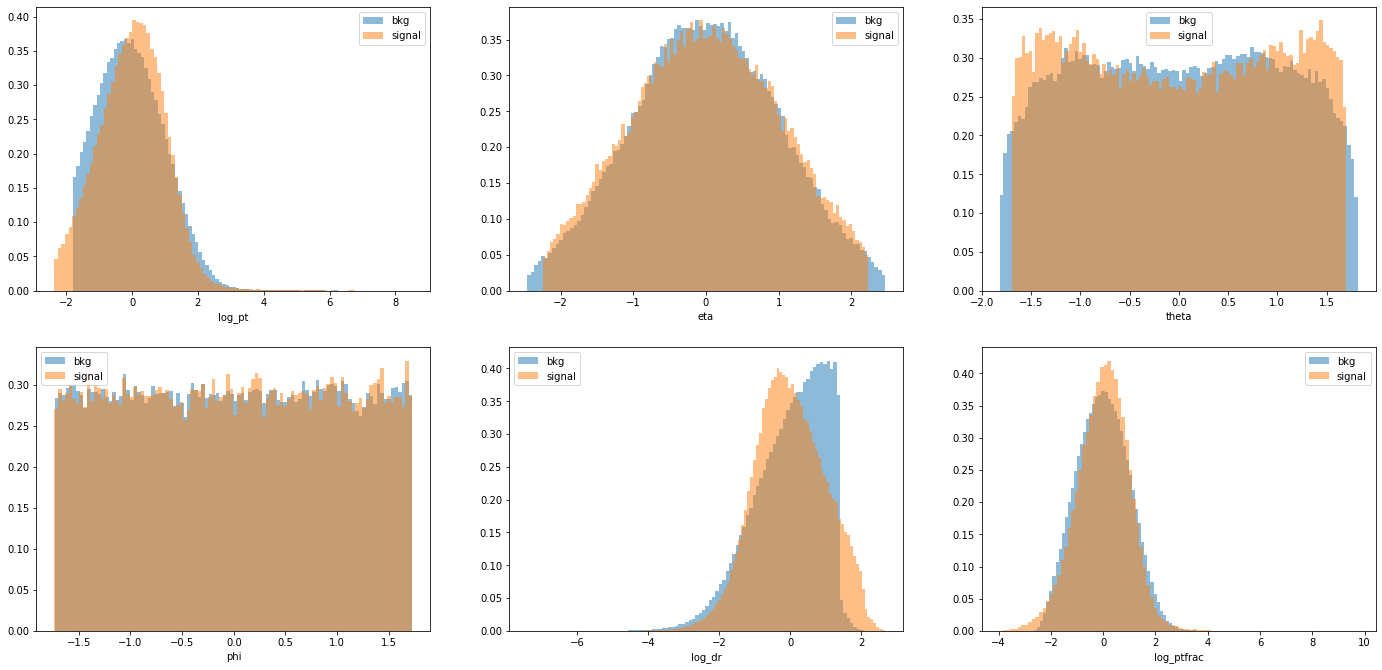

In [11]:
jet='wrongscaling'
signal_singleB,bkg_singleB=sig_bkg_selector(data_singleBTrk_prepr_cut)
X,y=dp_f.Sig_to_Bkg_eq(signal_singleB,bkg_singleB,0.01)

import os

data_out_dir=jet+'Jet/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_scaled, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_scaled,y_train,columns_list,True,'',path+data_out_dir)
